In [1]:
#1D non-isothermal
#I think we should still convert it to molar flowrates somehow!!!

'''To do for thursday meeting
 - NEED TO REDO THE A/V CALCULATION
 - compare non-constant dh Cp to experimental
 - convert the I2R term to furnace heating
'''

from scipy.integrate import solve_bvp
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def heats(T):
    #heats of reaction and heat capacity calculation from NIST
    t = T/1000

    #CH4
    A =	-0.703029
    B =	108.4773
    C =	-42.52157
    D =	5.862788
    E =	0.678565
    F =	-76.84376
    G =	158.7163
    H =	-74.87310

    dH_CH4 = A*t + B*t**2/2 + C*t**3/3 + D*t**4/4 - E/t + F - H
    Cp_CH4 = A + B*t + C*t**2 + D*t**3 + E/(t**2)

    #H2O
    A =   30.09200
    B =   6.832514
    C =   6.793435
    D =  -2.534480
    E =   0.082139
    F =  -250.8810
    G =   223.3967
    H =  -241.8264

    dH_H2O = A*t + B*t**2/2 + C*t**3/3 + D*t**4/4 - E/t + F - H
    Cp_H2O = A + B*t + C*t**2 + D*t**3 + E/(t**2)

    #CO
    A =   25.56759
    B =   6.096130
    C =   4.054656
    D =  -2.671301
    E =   0.131021
    F =  -118.0089
    G =   227.3665
    H = -110.5271

    dH_CO = A*t + B*t**2/2 + C*t**3/3 + D*t**4/4 - E/t + F - H
    Cp_CO = A + B*t + C*t**2 + D*t**3 + E/(t**2)

    #CO2
    A =   24.99735
    B =   55.18696
    C =  -33.69137
    D =   7.948387
    E =  -0.136638
    F =  -403.6075
    G =   228.2431
    H =  -393.5224

    dH_CO2 = A*t + B*t**2/2 + C*t**3/3 + D*t**4/4 - E/t + F - H
    Cp_CO2 = A + B*t + C*t**2 + D*t**3 + E/(t**2)

    #H2
    A =  33.066178
    B = -11.363417
    C =  11.432816
    D = -2.772874
    E = -0.158558
    F = -9.980797
    G =  172.707974
    H =  0.0

    dH_H2 = A*t + B*t**2/2 + C*t**3/3 + D*t**4/4 - E/t + F - H
    Cp_H2 = A + B*t + C*t**2 + D*t**3 + E/(t**2)

    #Ar
    A =	20.78600
    B =	2.825911*10**-7
    C =	-1.464191*10**-7
    D =	1.092131*10**-8
    E =	-3.661371*10**-8
    F =	-6.197350
    G =	179.9990
    H =	0

    Cp_Ar = A + B*t + C*t**2 + D*t**3 + E/(t**2) #J/mol K

    dHsmr = (3*dH_H2 + dH_CO - dH_CH4 - dH_H2O + 206.1)*10**3 #J/mol
    dHwgs = (dH_H2 + dH_CO2 - dH_CO - dH_H2O - 41.15)*10**3 #J/mol
    # print(dHsmr)
    # print(dHwgs)
    # print([Cp_CH4, Cp_H2O, Cp_CO, Cp_CO2, Cp_H2])
    return dHsmr, dHwgs, [Cp_CH4, Cp_H2O, Cp_CO, Cp_CO2, Cp_H2, Cp_Ar]

In [3]:
#WANT TO RE-ARANGE CONSTANTS

#reactor constants
L = 0.0609 #m
R_inner = 2.39/1000 #m
R_outer = 3.5/1000 #m

A = np.pi * ((R_outer*100)**2-(R_inner*100)**2) #cm^2 MIGHT HAVE TO ADJUST THE AREA CALC A BIT
V = A*L/(100**2) #m^3
S = 2*np.pi*R_outer*L #m^2

h2Removal = 0 #change to 1 if there is removal of hydrogen

#gas flow constants WHEN CHANGING THE TEMPERATURE YOU NEED TO ADJUST THE INITIAL GUESS -- USING ODEINT MIGHT BE FOR BETTER CONVERSION
Tin = 622+273 #K
P = 1 #bar or atm

sccm0 = np.array([16.16, 48.48, 0, 0, 10, 5])
mols0 = sccm0/22400 * 60
y0 = mols0/sum(mols0)
y0 = np.concatenate((y0, [Tin]))
print(y0)

u0 = sum(sccm0) * 273 / Tin * P / 1 / 60 #cm^3/sec
v0 = u0 / A / 100 #m/sec

#rate equation constants
Rgas = 8.314 #J / mol·K
Easmr = 165.740 #kJ/mol
Asmr = 1.68*10**8
Eawgs = 89.23 #kJ/mol
Awgs = 9.90*10**3

Ku = 1

I = 9 #curent in Amps
F = 96485 #faradays constant

U = 0.116 #J (s K)^-1.
Ts = 298 #K

Iheat = 1
Resist = 20

[2.02913109e-01 6.08739327e-01 0.00000000e+00 0.00000000e+00
 1.25565043e-01 6.27825213e-02 8.95000000e+02]


In [ ]:
x_num = 100

x_pts = np.linspace(0,L,x_num)

#initial guess array
init_guess = np.zeros((7, x_num))
init_guess[6, :] = Tin

if Tin == 721+273:
    init_guess[0, :] = 0.05
    init_guess[1, :] = 0.3
    init_guess[2, :] = 0.1
    init_guess[3, :] = 0.1
    init_guess[4, :] = 0.7    
    init_guess[5, :] = 0.1
elif Tin == 573+273:
    init_guess[0, :] = 0.1
    init_guess[1, :] = 0.5 
    init_guess[2, :] = 0.05
    init_guess[3, :] = 0.05   
    init_guess[4, :] = 0.3   
    init_guess[5, :] = 0.1
else:
    # Tin == 622+273:
    init_guess[0, :] = 0.2
    init_guess[1, :] = 0.5 
    init_guess[2, :] = 0.1
    init_guess[3, :] = 0.1    
    init_guess[4, :] = 0.5    
    init_guess[5, :] = 0.1

def odes(x, y): #dy/dt = f(x)
    #NEED TO ADJUST THIS. THESE ARE NOT CONCENTRATIONS, THEY ARE MOL FRACTIONS
    Cch4 = y[0]
    Ch2o = y[1]
    Cco = y[2]
    Cco2 = y[3]
    Ch2 = y[4]
    T = y[6]
    # print(T)

    Keqsmr = (101325/100000)**2 * np.exp(-26830/T + 30.114)
    Keqwgs = np.exp(4400/T - 4.036)
    Ctot = P/(8.3144598 * 10**-5 * T)

    '''the velocity would also be dependent on the temperature'''
    v = v0*(3*y0[0] - 2*Cch4)/y0[0] # v0*(1+2X)
    # print(len(v))
    
    '''NEED TO REDO THE A/V CALCULATION'''
    rsmr = 2/R_outer*Ku*Asmr*np.exp(-Easmr*1000/Rgas/T)*(Cch4*Ch2o-(P**2)*Cco*(Ch2**3)/Keqsmr)/Ctot
    rwgs = 2/R_outer*Ku*Awgs*np.exp(-Eawgs*1000/Rgas/T)*(Ch2o*Cco-Cco2*Ch2/Keqwgs)/Ctot
    rh2r = I/(2*F*L)/Ctot #have not confirmed if this is correct

    dHsmr, dHwgs, Cps = heats(T)
    # print(dHsmr)
    # print(dHwgs)

    Cpg = np.sum(y[:6, :]*Cps, axis=0)
    # print(Cpg)

    ch4 = (-rsmr)/v
    h2o = (-rsmr - rwgs)/v
    co = (rsmr - rwgs)/v
    co2 = (rwgs)/v
    h2 = (3*rsmr + rwgs + h2Removal*rh2r)/v
    ar = np.zeros(len(Cch4))
    #heat capacities are in kJ/mol so then 
    Temp = (S*U*(-T[:] + Ts) - S*(dHsmr*rsmr + dHwgs*rwgs) + Iheat**2 * Resist)/(v*Ctot*Cpg*V)
    
    return np.vstack([ch4, h2o, co, co2, h2, ar, Temp])

def bcs(yleft, yright):
    return np.array(yleft-y0)   #ADD THE TEMPERATURE IN y0 BX ALSO NEEDS TO BE BC

soln = solve_bvp(odes, bcs, x_pts, init_guess, max_nodes=100, tol = 0)

C:\Users\Alexa\AppData\Local\Temp\ipykernel_6520\4077370203.py:77: UserWarning: `tol` is too low, setting to 2.22e-14
  soln = solve_bvp(odes, bcs, x_pts, init_guess, max_nodes=100, tol = 0)


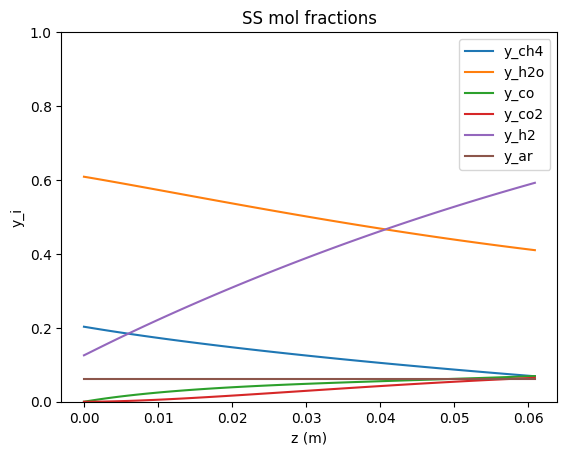

In [5]:
plt.plot(soln.x, soln.y[0], label='y_ch4')
plt.plot(soln.x, soln.y[1], label='y_h2o')
plt.plot(soln.x, soln.y[2], label='y_co')
plt.plot(soln.x, soln.y[3], label='y_co2')
plt.plot(soln.x, soln.y[4], label='y_h2')
plt.plot(soln.x, soln.y[5], label='y_ar')
plt.ylim(0, 1)
plt.xlabel('z (m)')
plt.ylabel('y_i')
plt.title('SS mol fractions')
plt.legend()

Text(0.5, 1.0, 'Temperature profile')

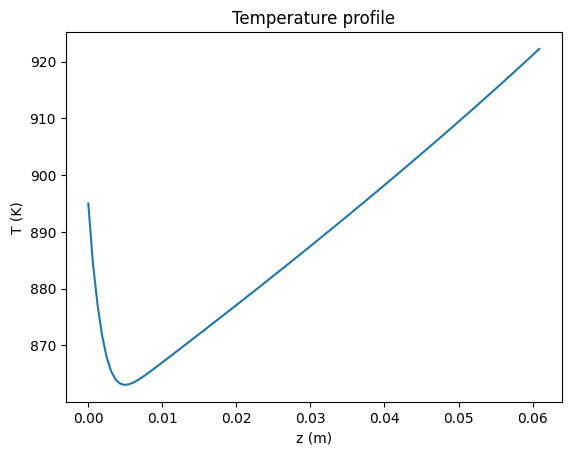

In [6]:
plt.plot(soln.x, soln.y[6])
plt.xlabel('z (m)')
plt.ylabel('T (K)')
plt.title('Temperature profile')

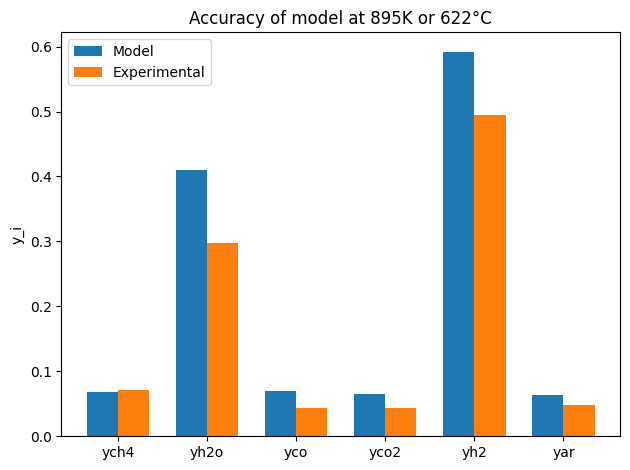

1.268044570250991


In [7]:
# Assign experimental data based on temperature
if Tin == 622 + 273:
    yexp = [0.071787506, 0.298008466, 0.043658696, 0.043658696, 0.495104008, 0.047782628]
elif Tin == 721 + 273:
    yexp = [0.019206098, 0.189598069, 0.090570208, 0.034350264, 0.619497555, 0.046777807]
elif Tin == 573 + 273:
    yexp = [0.101830373, 0.416886827, 0.02267593, 0.043676434, 0.365008486, 0.04992194]
elif Tin == 522 + 273:
    yexp = [0.135048125, 0.331577273, 0.010516725, 0.034486466, 0.436794105, 0.051577306]
else:
    print('Sorry, we don’t have experimental data for that temperature.')
    yexp = [0, 0, 0, 0, 0, 0]


# Define categories
categories = ['ych4', 'yh2o', 'yco', 'yco2', 'yh2', 'yar']
x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars

# Plot
fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, soln.y[:6,-1], width, label='Model')
bars2 = ax.bar(x + width/2, yexp, width, label='Experimental')

# Labels and legend
ax.set_ylabel('y_i')
ax.set_title(f'Accuracy of model at {Tin}K or {Tin - 273}°C')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

plt.tight_layout()
plt.show()

print(np.sum(soln.y[:6,-1]))